# Prediction challenge

### Predict the demand for the bike-sharing system (number of dropoffs and pickups)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

f=pd.read_csv("../data/Trips_2018.csv")


In [28]:
# step 1: customize the data table

print(f.dtypes)

f.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
f['starttime']=pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime']=pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f['usertype']=pd.Categorical(f['usertype'])
f['gender']=pd.Categorical(f['gender'])
f['start_station_id']=pd.Categorical(f['start_station_id'])
f['end_station_id']=pd.Categorical(f['end_station_id'])

bad_idx = f.index[f.isna().any(axis=1)]
print(bad_idx.tolist())
rows_with_na = f[f.isna().any(axis=1)]
print("rows_with_na first", rows_with_na)

f = f.dropna()

print(f.dtypes)
print(f)

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object
[10413518, 10413697, 10415434, 10415668, 10417031, 10417714, 10417770, 10421216, 10421276, 10422411, 10422596, 10422885, 10422892, 10423047, 10423230, 10423232, 10423388, 10423461, 10423832, 10423867, 10423879, 10423981, 10424026, 10424117, 10424185, 10424278, 10424294, 10424452, 10424591, 10425255, 10425520, 10425626, 10425772, 10426135, 10426607, 10427815, 10427993, 10428027, 10428296, 10428504, 10428784, 10428794, 10430531, 10433528, 10436246, 10438241, 10440685, 10443234, 10444360, 10444

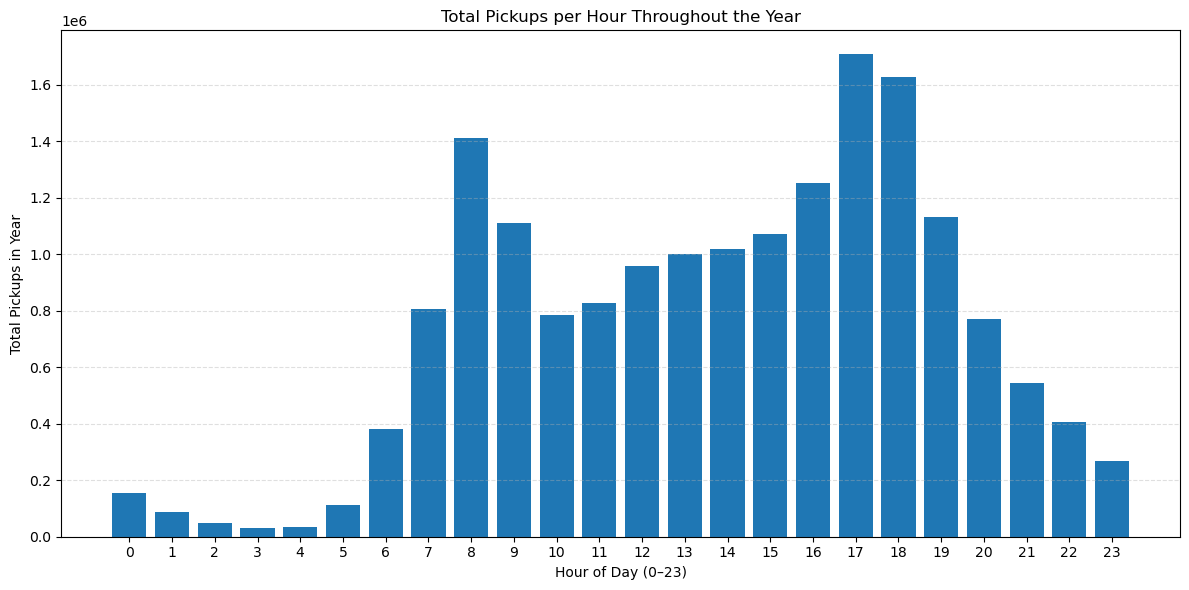

In [29]:
# Start by ploting the total pickup for each hour througout the year
# create an hour column
f['hour'] = f['starttime'].dt.hour

# --- Compute total pickups per hour ---
hourly_counts = f.groupby('hour').size()

# Ensure all 24 hours exist
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Pickups in Year")
plt.title("Total Pickups per Hour Throughout the Year")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

1) Cluster the stations spatially (nearby departing stations should be grouped together)
in no less than 20 clusters. Tasks 2 and 3 will be based on this clustering, and they
should be completed for at least two clusters (more is preferable) so that you can
compare their respective results and discuss them

In [30]:
from sklearn.cluster import KMeans

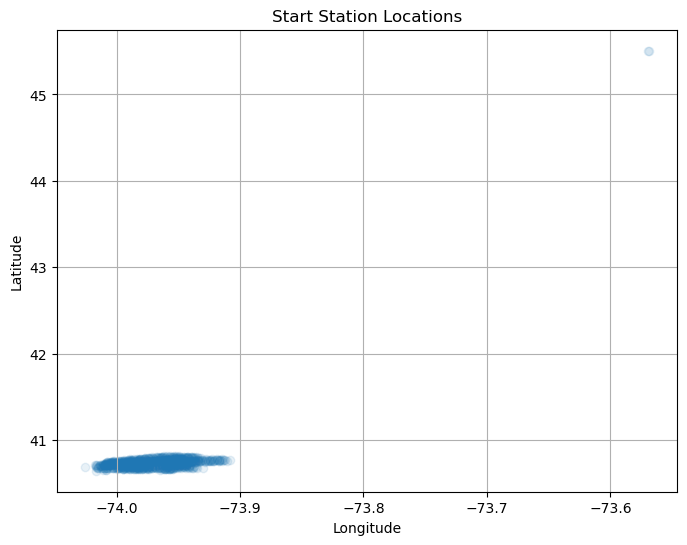

In [31]:
# Create a new DataFrame with start station ID and coordinates, then plot the locations
f_cluster = f[['start_station_id', 'start_station_latitude', 'start_station_longitude']]
f_cluster = f_cluster.drop_duplicates(subset='start_station_id')


plt.figure(figsize=(8, 6))
plt.scatter(f_cluster['start_station_longitude'], f_cluster['start_station_latitude'], alpha=0.1)

plt.title('Start Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [32]:
#There appears to be an outlier station far away from the other ones, let's find out which one it is and remove it
outlier_condition = (f_cluster['start_station_latitude'] > 41)
outlier_stations = f_cluster[outlier_condition]
print("Outlier stations:\n", outlier_stations)

Outlier stations:
        start_station_id  start_station_latitude  start_station_longitude
676612           3488.0               45.506364               -73.569463
714485           3650.0               45.506264               -73.568906


In [33]:
#Based on the latitude and longitude, stations 3488 and 3650 are located in Montreal, 
# so we will remove them from the clustering dataset and the original one
f_cluster = f_cluster[~outlier_condition]
f = f[f['start_station_latitude'] <= 41]


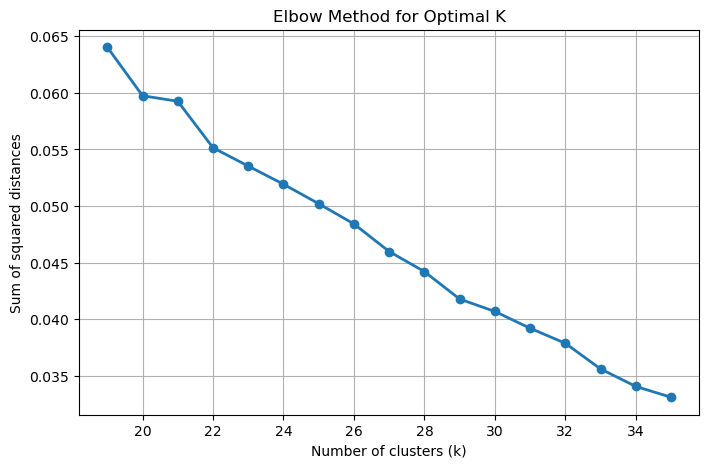

In [34]:
#Now, let's use the elbow method to determine the optimal number of clusters (k)
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

k_values = range(19, 36)
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'o-', linewidth=2)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()


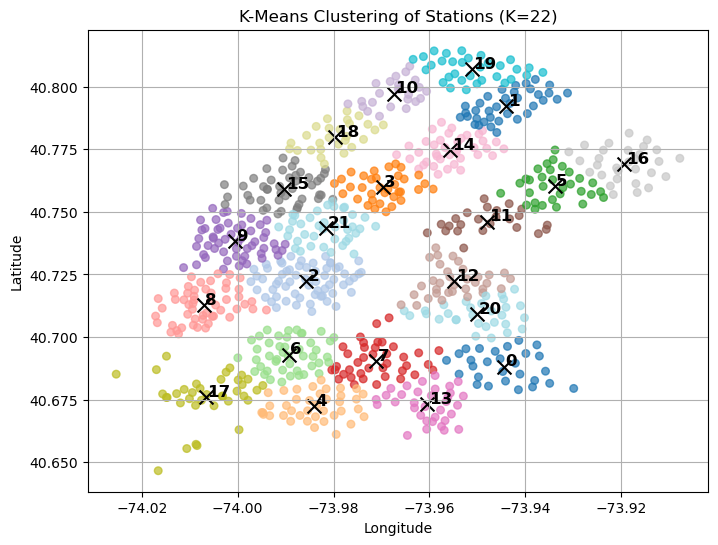

In [35]:
#We observe that k=22 should be a good choice for the number of clusters.

# Let's run the clustering and look at how the clusters look

# Extract coordinates
coords = f_cluster[['start_station_latitude', 'start_station_longitude']].values

# Run K-Means with 22 clusters
kmeans = KMeans(n_clusters=22, random_state=42)
f_cluster['cluster'] = kmeans.fit_predict(coords)

# Get cluster centers
centers = kmeans.cluster_centers_

# Plot data points colored by cluster
plt.figure(figsize=(8, 6))
plt.scatter(
    f_cluster['start_station_longitude'],
    f_cluster['start_station_latitude'],
    c=f_cluster['cluster'], cmap='tab20', s=30, alpha=0.7
)

# Plot cluster centers
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='black', s=100, marker='x'
)

# Add numeric labels at each cluster center
for i, (lat, lon) in enumerate(centers):
    plt.text(
        lon + 0.0003, lat + 0.0003,   # small offset
        str(i), 
        fontsize=12, fontweight='bold', color='black'
    )

plt.title('K-Means Clustering of Stations (K=22)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [36]:
# We want to only look at the clusters that make up the island of Manhattan
# We remove the other clusters from both f_cluster and f

clusters_to_remove = [0, 4, 5, 6, 7, 11, 12, 13, 16, 17, 20]

stations_to_remove = f_cluster.loc[
    f_cluster['cluster'].isin(clusters_to_remove),
    'start_station_id'
]

f = f[~f['start_station_id'].isin(stations_to_remove)]

# Add cluster column to original data frame
f = f.merge(
    f_cluster[['start_station_id', 'cluster']],  
    on='start_station_id',
    how='left'  
)


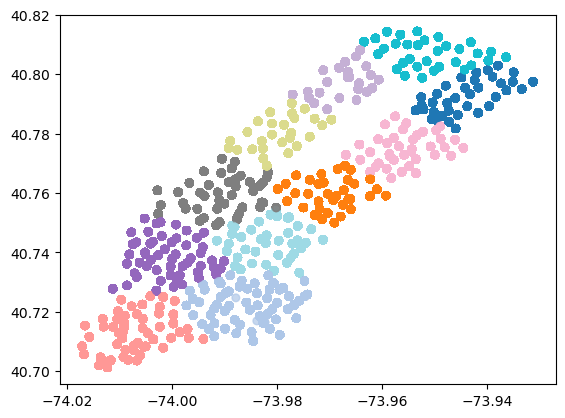

In [37]:
# Test to see if the correct clusters were removed
plt.scatter(f['start_station_longitude'], f['start_station_latitude'], c=f['cluster'], cmap='tab20', s=30, alpha=0.7)
plt.show()


2) You are expected to build a prediction model that, at the end of a day, allows to
predict what the demand for a cluster of stations will be over the next 24 hours – i.e.
not the total demand for the next day, but how the time-series of the demand will look
like for the next day (e.g., given demand data until midnight of day 1, predict the
number of pickups for all 1h intervals (12-1am, 1-2am, 6-7am, 7-8am, …, 11-12pm)
in day 2). You should predict both the arrivals (i.e., bicycle dropoffs) and the
departures (pickups). You should use a time aggregation of one hour or less. You
can choose to use two different models or a single one to predict both. It is up to you
to determine the most effective way to formulate this problem as a machine learning
problem. You should not shuffle the data. You should instead use the data from
January to October (included) to train your model, and the data from November and
December as a test set. You can use any model you want

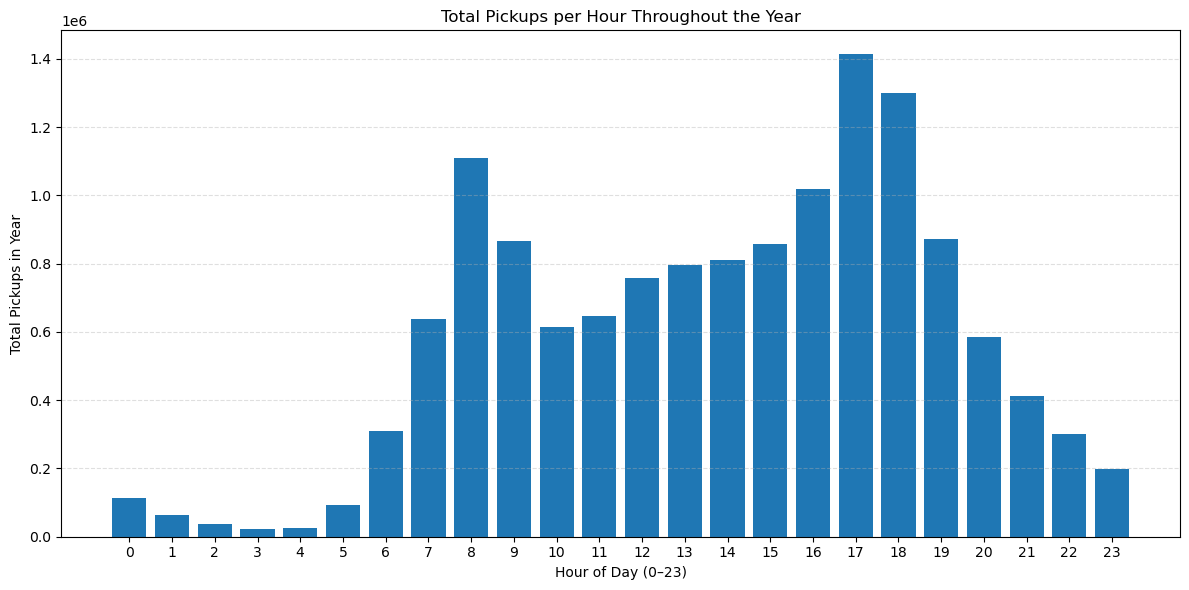

In [38]:
# Now let's plot the total pickup for each hour througout the year for the chosen clusters
# create an hour column
f['hour'] = f['starttime'].dt.hour

# --- Compute total pickups per hour ---
hourly_counts = f.groupby('hour').size()

# Ensure all 24 hours exist
hourly_counts = hourly_counts.reindex(range(24), fill_value=0)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Total Pickups in Year")
plt.title("Total Pickups per Hour Throughout the Year")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [39]:
# --- Assumptions ---

# Station id column:
station_col = f['start_station_id']  # adjust if different

# --- Build day & hour keys ---
f['day']  = f['starttime'].dt.day    # midnight-normalized dates (YYYY-MM-DD as Timestamp)
f['hour'] = f['starttime'].dt.hour            # 0..23

# --- Group by cluster/day/hour and pivot to day x hour ---
grp = f.groupby(['cluster', 'day', 'hour']).size()

# Make sure all 24 hours exist in every pivot
def pivot_cluster(g):
    df = (g.unstack('hour', fill_value=0)
            .reindex(columns=range(24), fill_value=0))
    return df

cluster_pivot = grp.groupby(level='cluster', group_keys=False).apply(pivot_cluster)

# --- Ensure all days in your year appear, even if zeros (nice for modeling) ---
date_min = f['day'].min()
date_max = f['day'].max()
all_days = pd.date_range(date_min, date_max, freq='D')

def reindex_days(df):
    return df.reindex(all_days, fill_value=0)

#cluster_pivot = cluster_pivot.groupby(level='cluster', group_keys=True)\
#                             .apply(reindex_days)

# Now `cluster_pivot` has a MultiIndex row (cluster, day) and columns 0..23.
# If you prefer separate tables per cluster:
cluster_tables = {
    c: cluster_pivot.xs(c, level='cluster').rename_axis('day')
    for c in cluster_pivot.index.get_level_values('cluster').unique()
}

# change the number to see for each cluster
cluster_tables[8]



hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
1,410,273,165,77,83,183,810,1567,3183,2855,...,3643,3767,5119,8265,6505,3712,2397,1438,1004,553
2,304,172,93,56,71,191,818,1553,3122,2727,...,3246,3348,4564,7485,6626,3746,2296,1431,875,562
3,325,171,118,63,75,191,809,1671,3161,2825,...,3147,3456,4286,6632,5400,3194,2160,1436,881,546
4,410,199,124,57,68,162,735,1531,2950,2580,...,3253,3552,4487,6414,5909,3730,2304,1508,1116,691
5,363,196,107,92,82,238,1008,1958,3592,2989,...,3163,3370,4561,8032,6993,4134,2562,1530,1015,586
6,337,181,98,73,87,241,946,1873,3526,2783,...,2894,3172,4145,7314,6253,3736,2321,1571,1100,619
7,369,203,147,62,68,219,911,1820,3460,2874,...,3391,3464,4504,7440,6364,3611,2169,1517,944,639
8,329,228,139,76,85,221,886,1614,3193,2853,...,3493,3725,4633,7339,6446,3801,2410,1516,983,619
9,390,218,107,57,84,230,929,1998,3734,3175,...,2906,2963,4120,7538,6498,3737,2352,1456,938,606


In [14]:
# Byrja næsta part hér ........

3) Overnight, the bike-sharing company manually repositions its bikes to ensure that
demand for the next day can be met. You are expected to use the outputs from the
prediction model above to compute the required number of bicycles to be placed in
each cluster of stations analyzed in Task 2 at the beginning of the next day. To
compute this number, you can use the cumulative of the arrivals and departures. The
goal is to ensure that, over the duration of the next day, there will never be a shortage
of bikes – or, if there is, the goal is to minimize the number of bikes in deficit. The
number of bicycles required can be estimated by extrapolating the maximum
difference between the number of departures and arrivals.